In [99]:
import pymongo
import spacy
import decouple
import glob
import datetime
from PIL import Image
from IPython.display import display
from tqdm.notebook import tqdm
from pytrends.request import TrendReq
import tweepy
import os
from io import BytesIO
from google.cloud import storage

config = decouple.AutoConfig(' ')
nlp = spacy.load("en_core_web_lg")
pytrends = TrendReq(hl='en-US', tz=360)

bucket_name = 'sideb-proejct.appspot.com'
bucket_dir = 'piixur/'

In [100]:
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = os.path.abspath(os.path.join(os.getcwd(), 'config/sideb-proejct-0e33d8c0b0a9.json'))

In [101]:
storage_client = storage.Client()
buckets = list(storage_client.list_buckets())
buckets

[<Bucket: gcf-sources-630659159765-us-central1>,
 <Bucket: sideb-proejct.appspot.com>,
 <Bucket: staging.sideb-proejct.appspot.com>,
 <Bucket: us.artifacts.sideb-proejct.appspot.com>]

In [129]:
gsearch = 'art'
pytrends.build_payload([gsearch], timeframe='now 1-d')
qrys = pytrends.related_queries()[gsearch]['rising']['query'].values
trend = ' '.join([_q.replace(gsearch, '').replace('  ', ' ').strip() for _q in qrys])
trend

'metal of wisconsin provincia experta mother bird asoci cual es mi prevencion galeno museum fireworks 4th of july clip chelsea lee 4th of july pictures clip free rsl union 4th of july animal crossing guide animal crossing acnh guide reina sofia coney walls redd guide'

In [130]:
client = pymongo.MongoClient(config('MONGODB_URI'))
client.list_database_names()
db = client.Cluster0
db.list_collection_names()

['test', 'pix', 'feedlog']

In [131]:
colpix = db.pix
colpix.count_documents({})

400

In [132]:
# cursor = colpix.find(
#     {'$text': {'$search': 'happy'}}, 
#     {'score': {'$meta': 'textScore'}}
# )

# cursor.sort([('score', {'$meta': 'textScore'})])

In [133]:
pixs = list(colpix.find({ 'feed_id': {'$exists': False}})); len(pixs)

400

In [134]:
sims = []
for _p in tqdm(pixs):
    sims.append((_p['hash'], nlp(trend).similarity(nlp(_p['labels'] + ' ' + _p['colors']))))
    
sims = sorted(sims, key=lambda x: -x[1])
sims[:5]

  0%|          | 0/400 [00:00<?, ?it/s]

[('0b518176b2796c6dba2c3fb94170d58492b9bbb35df06a620e0624e63d1fcb01',
  0.7170774751926596),
 ('e3c62647447dcb709223ddeb3c4d9c6fa21306bedc60b2cd2f7fae474be560f0',
  0.693466725543012),
 ('7220361219949e11c6d75535607a87039ad5df0fb804b8c0856f2a144052d09c',
  0.6862787343302941),
 ('d5369ba15702821657947641094646739e4b09d0e1b151bb457bdb62414d6154',
  0.6816581278821544),
 ('2f577cf3bc3a77130dbfb11396c2599b99f6681a551800b2a0670ed6357c27c6',
  0.6766363588489112)]

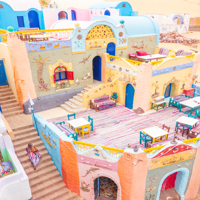

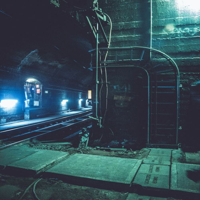

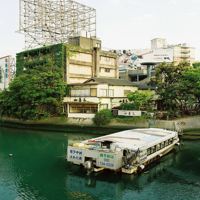

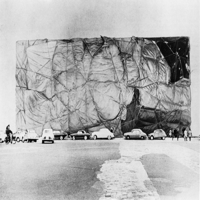

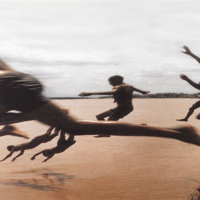

In [135]:
for _fname, _ in sims[:5]:
    _path = glob.glob('imgs/archive/' + _fname + '.*')[0]
    _img = Image.open(_path)
    _img = _img.resize((200, 200))
    display(_img)

In [41]:
_hash = sims[0][0]
pix = colpix.find_one({ 'hash': _hash }); pix

{'_id': ObjectId('62bea357e52ff7c41eae0e07'),
 'labels': 'lipstick gesture font poster art illustration fictional_character eyelash formal_wear music carmine advertising graphics entertainment book_cover suit movie',
 'urls': ['https://collektor.tumblr.com/post/187426423945'],
 'colors': 'black silver white',
 'hash': 'ec00e07daed80d660d19bb2744ebbe40ef3a0ee71757b47c3b0525293ea1518f',
 'created_at': datetime.datetime(2022, 7, 1, 7, 33, 43, 253000)}

In [42]:
url = pix['urls'][0]; url

'https://collektor.tumblr.com/post/187426423945'

In [51]:
# pix_upload = glob.glob('imgs/archive/' + _hash + '.*')[0]; pix_upload

In [50]:
blobs = list(storage_client.list_blobs(bucket_name, prefix=bucket_dir+pix['hash'])); blobs

[<Blob: sideb-proejct.appspot.com, piixur/ec00e07daed80d660d19bb2744ebbe40ef3a0ee71757b47c3b0525293ea1518f.jpg, 1656660823927844>]

In [52]:
blob = blobs[0]; blob

<Blob: sideb-proejct.appspot.com, piixur/ec00e07daed80d660d19bb2744ebbe40ef3a0ee71757b47c3b0525293ea1518f.jpg, 1656660823927844>

In [84]:
file = BytesIO(blob.download_as_bytes()); file

In [39]:
#status = 'crawled from ' + url; status

In [85]:
bearer_token = config('TWITTER_BEARER_TOKEN')
consumer_key = config('TWITTER_CONSUMER_KEY')
consumer_secret = config('TWITTER_CONSUMER_SECRET')
access_token = config('TWITTER_ACCESS_TOKEN')
access_token_secret = config('TWITTER_ACCESS_TOKEN_SECRET')

auth = tweepy.OAuth1UserHandler(consumer_key, consumer_secret, access_token, access_token_secret)
api = tweepy.API(auth)

In [86]:
# media = api.media_upload(filename=pix_upload)
media = api.media_upload(filename='0', file=file)
api.create_media_metadata(media.media_id_string, url)
status = api.update_status(status='', media_ids=[media.media_id_string]);

In [78]:
status.id

1543928684385406976

In [93]:
res = colpix.update_one(
        { 'hash': _hash }, 
        { '$set': { 'feed_id': status.id }}
    )
res

In [98]:
res.upserted_id

In [33]:
_timeline = api.user_timeline(); _timeline

[Status(_api=<tweepy.api.API object at 0x7fcf11f6e700>, _json={'created_at': 'Sun Jun 26 08:35:52 +0000 2022', 'id': 1540977132155043841, 'id_str': '1540977132155043841', 'text': 'https://t.co/RPnFTsMu9x', 'truncated': False, 'entities': {'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [], 'media': [{'id': 1540977125377081345, 'id_str': '1540977125377081345', 'indices': [0, 23], 'media_url': 'http://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg', 'media_url_https': 'https://pbs.twimg.com/media/FWKmh_UagAE9Dt2.jpg', 'url': 'https://t.co/RPnFTsMu9x', 'display_url': 'pic.twitter.com/RPnFTsMu9x', 'expanded_url': 'https://twitter.com/piixur/status/1540977132155043841/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1102, 'h': 1200, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'small': {'w': 624, 'h': 680, 'resize': 'fit'}, 'large': {'w': 1280, 'h': 1394, 'resize': 'fit'}}}]}, 'extended_entities': {'media': [{'id': 1540977125377081345, 'id_str': '1540977125377